# Ch 7 - Inference and Statistical Testing

This notebook contains python code for generating figures in the Chapter 7 of the book _Mathematics in Biology_.

## Imports and utilities

In [ ]:
import numpy as np
import random
from random import seed

from pathlib import Path
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import poisson, binom, t, norm, chi2, uniform, expon
from scipy import special

# set font to be used in figures
import matplotlib.font_manager as font_manager
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'serif';
cmfont = font_manager.FontProperties(fname=matplotlib.get_data_path() + '/fonts/ttf/cmr10.ttf');
matplotlib.rcParams['font.serif']=cmfont.get_name();
matplotlib.rcParams['axes.formatter.use_mathtext'] = True
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams['font.size'] = 11

Save = False # set to True if you are saving figures to a local drive
if Save:
    # set path to save the figures
    savedir = Path('..\img')
    savedir.mkdir(parents=True, exist_ok=True)

datadir = Path('data')

In [15]:
# Utilities for plotting

def plot(X, Y=None, xlabel=None, ylabel=None, legend=[], loc=None, title=None, alpha=1.0,
         xlim=None, ylim=None, xscale='linear', yscale='linear',
         xticks=None, yticks=None, xhide=False, yhide=False, yrot=False,
         xzero=False, yzero=False, yflip=False,
         fmts=['r-','g-','b-','y-','c-','m-'], linewidth=2, markersize=5, fillstyle='full',
         markeredgewidth=1, rasterized=False,
         grid=False, equal=False, figsize=(5,3), axes=None):
    """
    Plot data points.
    X: an array or list of arrays
    Y: an array or list of arrays
    If Y exists then those values are plotted vs the X values
    If Y doesn't exist the X values are plotted
    xlabel, ylabel: axis labels
    legend: list of labels for each Y series
    loc: location of the legend, like 'upper right'
    title: duh
    xlim, ylim: [low,high] list of limits for the 2 axes
    xscale, yscale: 'linear' or 'log'
    xticks, yticks: list of locations for tick marks, or None for auto ticks
    yhide: hide the y axis?
    yrot: rotate the yaxis label to horizontal?
    yzero: zero line for the y-axis?
    fmts: a list of format strings to be applied to successive Y-series
    linewidth, markersize, fillstyle, markeredgewidth: see docs
    grid: draw a grid?
    equal: use equal aspect ratio, i.e. same scale per unit on x and y axis?
    figsize: (h,v) in inches
    rasterized: rasterize the data portion of the graph?
    axes: pre-existing axes where to draw the plot
    Returns: axes for the plot
    """

    if not axes: # start a new figure
        fig = plt.figure(figsize=figsize)
        axes = plt.gca()

    def has_one_axis(X): # Return True if X (ndarray or list) has 1 axis
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    # axes.cla() # clears these axes
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt, linewidth=linewidth, markersize=markersize,
            	fillstyle=fillstyle,markeredgewidth=markeredgewidth,
            	rasterized=rasterized, alpha=alpha)
        else:
            axes.plot(y, fmt, linewidth=linewidth, markersize=markersize,
            	fillstyle=fillstyle,markeredgewidth=markeredgewidth,
            	rasterized=rasterized, alpha=alpha)
    set_axes(axes, xlabel, ylabel, legend, loc, xlim, ylim, xscale, yscale,
             xticks, yticks, xhide, yhide, yrot, xzero, yzero, yflip, grid, equal)
    if title:
        plt.title(title)
    plt.tight_layout()

    return axes # useful if we started a new figure

def hist(X, bins=50, range=None, density=None, weights=None, histtype='stepfilled', stacked=False,
         align='mid', color=['r','g','b','m'], alpha=0.5, linewidth=1,
         xlabel=None, ylabel=None, legend=[], loc=None, title=None,
         xlim=None, ylim=None, xscale='linear', yscale='linear',
         xticks=None, yticks=None, xhide=False, yhide=False, yrot=False,
         xzero=False, yzero=False, yflip=False,
         grid=False, figsize=(5,3), axes=None, orientation='vertical'):
    """
    Histogram data.
    X: an array or list of arrays to be histogrammed
    bins: the number of bins, or a list of edges
    range: [low,high] the range over which the bins are spread
    density: normalize to unit area?
    weights: array same shape as X; each value in X only contributes that weight.
    histtype: 'bar','barstacked','step','stepfilled'
    stacked: plot multiple series on top of each other?
    align: 'left','mid',right', center the bar on left edge, center, or right edge of bin
    color: list of colors for the data series
    alpha: opacity, useful if histtype='stepfilled'
    xlabel, ylabel: axis labels
    legend: list of labels for each Y series
    loc: location of the legend, like 'upper right'
    title: duh
    xlim, ylim: [low,high] list of limits for the 2 axes
    xscale, yscale: 'linear' or 'log'
    xticks, yticks: list of locations for tick marks, or None for auto ticks
    yhide: hide the y axis?
    yrot: rotate the yaxis label to horizontal?
    yzero: zero line for the y-axis?
    grid: draw a grid?
    figsize: (h,v) in inches
    axes: pre-existing axes where to draw the plot
    Returns: axes, n, bins, patches
    """

    if not axes: # start a new figure
        fig,ax = plt.subplots(figsize=figsize)
    else:
    	ax=axes

    def has_one_axis(X): # Return True if X (ndarray or list) has 1 axis
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        ndata=1
    else:
        ndata=len(X) # assuming it is an ndarray or a list of lists

    if len(color)<ndata: # if there aren't enough dolors provided
        col=None # use the default color sequence
    else:
        col=color[:ndata]

    if histtype=='step' or histtype=='stepfilled': # in these cases the legend sequence needs to be inverted for some reason
        if isinstance(legend, list):
        	legend = legend[-1::-1]

    n, bins, patches = ax.hist(X, bins=bins, range=range, density=density, weights=weights,
                                 histtype=histtype, stacked=stacked, align=align,
                                 color=col, alpha=alpha, linewidth=linewidth,
                                 label=legend, orientation=orientation)

    set_axes(ax, xlabel, ylabel, legend, loc, xlim, ylim, xscale, yscale,
    	xticks, yticks, xhide, yhide, yrot, xzero, yzero, yflip, grid, equal=False)

    if title:
        plt.title(title)
    if not axes:
    	plt.tight_layout() # otherwise let the caller take care of layout

    return ax, n, bins, patches # useful if we started a new figure

def set_axes(axes, xlabel, ylabel, legend, loc, xlim, ylim, xscale, yscale,
    	xticks, yticks, xhide, yhide, yrot, xzero, yzero, yflip, grid, equal):
    """Set the axes for matplotlib."""
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    if xlim:
        axes.set_xlim(xlim)
    else:
        axes.set_xlim(auto=True)
    if ylim:
        axes.set_ylim(ylim)
    else:
        axes.set_ylim(auto=True)
    if grid:
        axes.grid()
    if equal:
        axes.set_aspect(aspect='equal')
    if ylabel:
        if yrot:
            axes.set_ylabel(ylabel, fontsize=12, rotation=0, labelpad=15)
        else:
            axes.set_ylabel(ylabel, fontsize=12)
    if xlabel:
        axes.set_xlabel(xlabel, fontsize=12)
    axes.get_yaxis().set_visible(not yhide)
    axes.get_xaxis().set_visible(not xhide)
    if xzero:
        axes.axvline(color='black', linewidth=0.5)
    if yzero:
        axes.axhline(color='black', linewidth=0.5)
    if yflip:
        axes.invert_yaxis()
    axes.tick_params(axis = 'both', which = 'major', labelsize = 10)
    axes.tick_params(axis = 'both', which = 'minor', labelsize = 9)
    if xticks != None:
        axes.set_xticks(xticks); # no minor ticks
    if yticks != None:
        axes.set_yticks(yticks); # no minor ticks
    if legend:
        axes.legend(legend, loc=loc)
    plt.draw()
    #     To change the font and control the fontsize, can use some of these commands:
    #     axes.set_xlabel(xlabel, fontname='Arial', fontsize = 12)
    #     axes.set_ylabel(ylabel, fontname='Arial', fontsize = 12)
    #     axes.tick_params(axis = 'both', which = 'major', labelsize = 10)
    #     axes.tick_params(axis = 'both', which = 'minor', labelsize = 9)
    #     plt.yticks(fontname = "Arial")
    #     plt.xticks(fontname = "Arial")
    #     if legend:
    #         axes.legend(legend, prop={"size":12, "family":'Arial'})
    #     For options on legend placement see https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot

def test_plot():
    x = np.arange(-10,10,.01)
    t = [0.1,0.3,1,3,10]
    y = [np.exp(-x**2/(4*ti))/np.sqrt(4*np.pi*ti) for ti in t]
    plot (x,y,fmts=['r-','g-','b-','y-','c-','m-'],linewidth=1,
        xlabel='Distance',ylabel='Concentration',yzero=True,
        legend=['t=0.1','0.3','1','3','10'],xticks=[-10,-5,-1,0,1,5,10])

### Inference and statistical testing

(0.9, 0.458, 0.883)

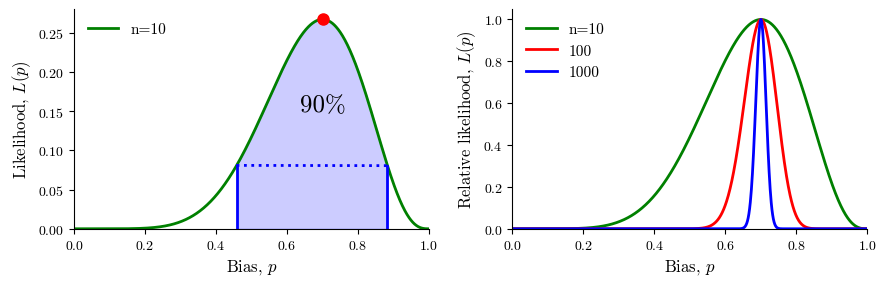

In [16]:
fig,ax=plt.subplots(1,2,figsize=(9,3))

N=10
m=7
p=np.arange(0.0,1.0,0.001)
# likelihood
L=(np.math.factorial(N)/(np.math.factorial(m)*np.math.factorial(N-m)))*p**(m)*(1-p)**(N-m)

# integral of the likelihood
u=np.cumsum(L)
u/=u[-1] # normalize to 1

# Find the confidence limits
f=0.9 # fraction of likelihood inside limits
for i1 in range(len(p)): # for every p1
    u2=u[i1]+f # find the p2 so that [p1,p2] contains area f
    i2=np.where(u>u2)[0][0] 
    if L[i2]<L[i1]: # if L(p2) drops below L(p1) stop
        break

N=[10,100,1000]
M=[7,70,700]
p=np.arange(0.0,1.0,0.001)
# likelihood
L=np.array([(np.math.factorial(n)/(np.math.factorial(m)*np.math.factorial(n-m)))*p**(m)*(1-p)**(n-m)
   for n,m in zip(N,M)])
L10=L[0].copy()
L/=np.max(L,axis=-1).reshape(-1,1)

plot(p,L10,fmts=['g-'],axes=ax[0]);
plot([p[i1],p[i2]],[L10[i1],L10[i2]],fmts=['b:'],axes=ax[0],
    yzero=True,
     xlabel='Bias, $p$',
     ylabel='Likelihood, $L(p)$',
     legend=['n={}'.format(N[0])],
     loc='upper left',
);
plot([p[i1],p[i1]],[0,L10[i1]],fmts=['b-'],axes=ax[0]);
plot([p[i2],p[i2]],[0,L10[i2]],fmts=['b-'],axes=ax[0]);
plot([M[0]/N[0]],[np.max(L10)],fmts=['ro'],markersize=8,axes=ax[0],
    ylim=[0,0.28],
    xlim=[0,1],
);
ax[0].fill_between(p,L10,where=np.logical_and(p>p[i1],p<p[i2]), color='blue',alpha=0.2);
ax[0].text(0.7,0.15,'90%',fontsize=18,ha='center');

plot(p,L,fmts=['g-','r-','b-'],
     xlabel='Bias, $p$',
     ylabel='Relative likelihood, $L(p)$',
     legend=['n={}'.format(N[0])]+['{}'.format(n) for n in N[1:]],
    ylim=[0,1.05],
    xlim=[0,1],
     axes=ax[1],
);
ax[0].legend_.set_frame_on(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].legend_.set_frame_on(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
if Save:
    fig.savefig(str(savedir / 'inf-lik-coin.pdf'), dpi=600, format='pdf', bbox_inches='tight');
f,p[i1],p[i2]

n = 10, 99.0% CI = [0.396,0.642]
n = 100, 99.0% CI = [0.511,0.6950000000000001]
n = 1000, 99.0% CI = [0.647,0.721]


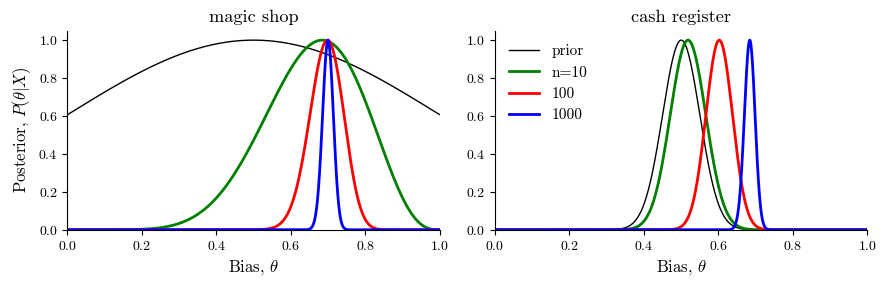

In [17]:
# Bayesian estimation, prior and posterior
fig,ax=plt.subplots(1,2,figsize=(9,3))
N=[10,100,1000]
M=[7,70,700]
p=np.arange(0.0,1.0,0.001)
# likelihood
L=np.array([(np.math.factorial(n)/(np.math.factorial(m)*np.math.factorial(n-m)))*p**(m)*(1-p)**(n-m)
   for n,m in zip(N,M)])
L/=np.max(L,axis=-1).reshape(-1,1)

si=0.5 # std dev of magic shop prior distrn
Q=np.exp(-(p-0.5)**2/(2*si**2)) # magic shop prior
Q/=np.max(Q,axis=-1)
P=L*Q
P/=np.max(P,axis=-1).reshape(-1,1)

plot(p,Q,fmts=['k-'],linewidth=1,axes=ax[0],)
plot(p,P,fmts=['g-','r-','b-'],
     xlabel=r'Bias, $\theta$',
     ylabel=r'Posterior, $P(\theta|X)$',
    ylim=[0,1.05],
    xlim=[0,1],
     axes=ax[0],
);
ax[0].set_title('magic shop')

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

si=0.05 # std dev of cash register prior distrn
Q=np.exp(-(p-0.5)**2/(2*si**2)) # cash register prior
Q/=np.max(Q,axis=-1)
P=L*Q
P/=np.max(P,axis=-1).reshape(-1,1)

plot(p,Q,fmts=['k-'],linewidth=1,axes=ax[1],)
plot(p,P,fmts=['g-','r-','b-'],
     xlabel=r'Bias, $\theta$',
#      ylabel=r'Posterior, $P(\theta|X)$',
    ylim=[0,1.05],
    xlim=[0,1],
     axes=ax[1],
    legend=['prior','n={}'.format(N[0])]+['{}'.format(n) for n in N[1:]],
     loc='upper left',
);
ax[1].set_title('cash register')

ax[1].legend_.set_frame_on(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
if Save:
    fig.savefig(str(savedir / 'inf-post-coin.pdf'), dpi=600, format='pdf', bbox_inches='tight');

# Find the confidence limits
f=0.99 # fraction of posterior inside limits
for n,X in zip(N,P): # for each of the 3 posteriors
    u=np.cumsum(X)
    u/=u[-1] # normalize to 1
    for i1 in range(len(p)): # for every p1
        u2=u[i1]+f # find the p2 so that [p1,p2] contains area f
        i2=np.where(u>u2)[0][0] 
        if X[i2]<X[i1]: # if L(p2) drops below L(p1) stop
            break
    print ('n = {}, {}% CI = [{},{}]'.format(n,f*100,p[i1],p[i2]))

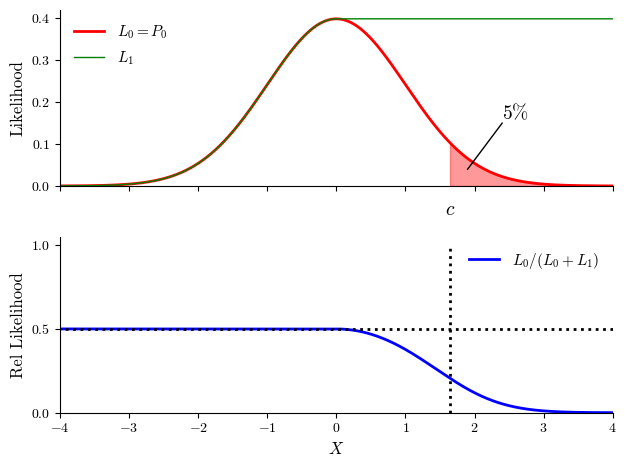

In [18]:
# z-test one-sided with alternative hypothesis mu>0
# one-tailed confidence limit at significance alpha
def conf(al):
    return np.sqrt(2)*special.erfcinv(2*al)

x=np.arange(-10,10,.001)
m1=0 # mean of P1
L0=1/np.sqrt(2*np.pi)*np.exp(-x**2/2) # normal distribution
L1=1/np.sqrt(2*np.pi)*np.exp(-(x-m1)**2/2) # normal distribution
L1[x>m1]=1/np.sqrt(2*np.pi)
al=0.05
c=conf(al)

fig,ax=plt.subplots(2,1)

plot(x,L0,axes=ax[0],fmts=['r-'],linewidth=2);
plot(x,L1,axes=ax[0],fmts=['g-'],linewidth=1,
     ylabel='Likelihood',
    xlim=[-4,4],
    ylim=[0,0.42],
     xticks=list(range(-4,5)),
     legend=['$L_0=P_0$','$L_1$'],
);
ax[0].fill_between(x,L0,where=x>c,color='red',alpha=0.4);

plot(x,L0/(L0+L1),axes=ax[1],
     fmts=['b-'],
);
plot([c,c],[0,1],fmts=['k:'],axes=ax[1],
    legend=[r'$L_0/(L_0+L_1)$'],
#     legend=[r'$\frac{L_0}{L_0+L_1}$'],
);
plot([min(x),max(x)],[0.5,0.5],fmts=['k:'],axes=ax[1],
    xlim=[-4,4],
     ylim=[0,1.05],
     xticks=list(range(-4,5)),
     yticks=list(np.arange(0,1.5,0.5)),
     xlabel='$X$',
     ylabel='Rel Likelihood',
);
ax[0].text(c,-0.07,r'$c$',size = 14, ha = 'center');
plot([1.9,2.4],[0.04,0.15],fmts=['k-'],linewidth=1,axes=ax[0]);
ax[0].text(2.4,0.15,r'$5\%$',size=14,ha='left',va='bottom');
ax[0].set_xticklabels([]);

ax[0].legend_.set_frame_on(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

ax[1].legend_.set_frame_on(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
if Save:
    fig.savefig(str(savedir / 'inf-hyp-z-oneside.pdf'), dpi=600, format='pdf', bbox_inches='tight');

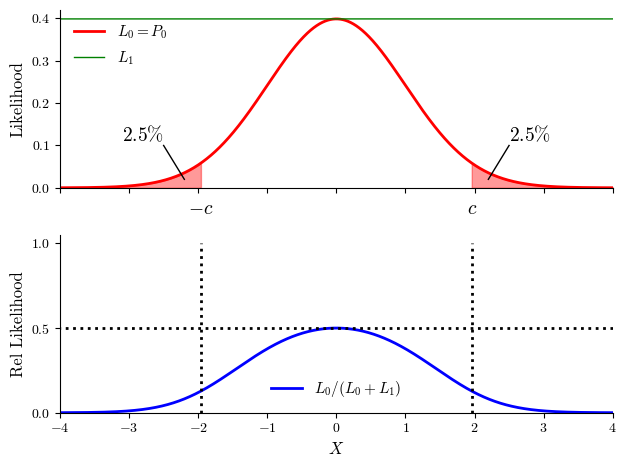

In [19]:
# z-test two-sided with alternative hypothesis mu = anything
def conf(al):
    return np.sqrt(2)*special.erfcinv(2*al)

x=np.arange(-10,10,.001)
m1=0 # mean of P1
L0=1/np.sqrt(2*np.pi)*np.exp(-x**2/2) # normal distribution
L1=1/np.sqrt(2*np.pi)*np.ones(len(x)) # constant
al=0.025
c=conf(al)

fig,ax=plt.subplots(2,1)

plot(x,L0,axes=ax[0],fmts=['r-'],linewidth=2);
plot(x,L1,axes=ax[0],fmts=['g-'],linewidth=1,
     ylabel='Likelihood',
    xlim=[-4,4],
    ylim=[0,0.42],
     xticks=list(range(-4,5)),
     legend=['$L_0=P_0$','$L_1$'],
     loc='upper left',
);
ax[0].fill_between(x,L0,where=x>c,color='red',alpha=0.4);
ax[0].fill_between(x,L0,where=x<-c,color='red',alpha=0.4);

plot(x,L0/(L0+L1),axes=ax[1],
     fmts=['b-'],
    legend=[r'$L_0/(L_0+L_1)$'],
);
plot([c,c],[0,1],fmts=['k:'],axes=ax[1],
);
plot([-c,-c],[0,1],fmts=['k:'],axes=ax[1],
);
plot([min(x),max(x)],[0.5,0.5],fmts=['k:'],axes=ax[1],
    xlim=[-4,4],
     ylim=[0,1.05],
     xticks=list(range(-4,5)),
     yticks=list(np.arange(0,1.5,0.5)),
     xlabel='$X$',
     ylabel='Rel Likelihood',
);
ax[0].text(c,-0.03,r'$c$',size = 14,ha='center',va='top');
ax[0].text(-c,-0.03,r'$-c$',size = 14,ha='center',va='top');
plot([2.2,2.5],[0.02,0.1],fmts=['k-'],linewidth=1,axes=ax[0]);
ax[0].text(2.5,0.1,r'$2.5\%$',size=14,ha='left',va='bottom');
plot([-2.2,-2.5],[0.02,0.1],fmts=['k-'],linewidth=1,axes=ax[0],
    xlim=[-4,4],
     ylim=[0,0.42],
);
ax[0].text(-2.5,0.1,r'$2.5\%$',size=14,ha='right',va='bottom');
ax[0].set_xticklabels([]);

ax[0].legend_.set_frame_on(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

ax[1].legend_.set_frame_on(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
if Save:
    fig.savefig(str(savedir / 'inf-hyp-z-twoside.pdf'), dpi=600, format='pdf', bbox_inches='tight');

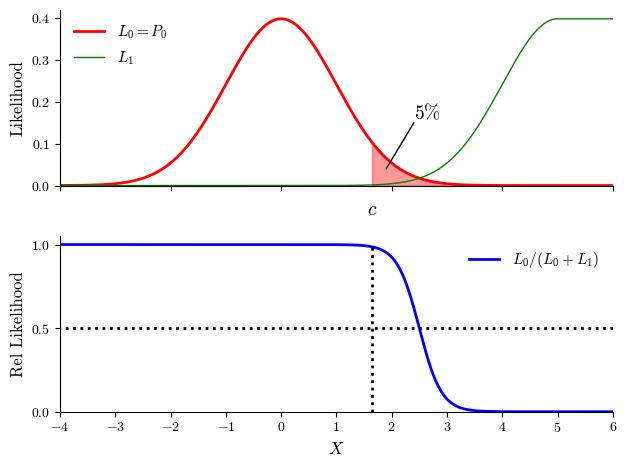

In [20]:
# absurd result of z-test with alternative hypothesis mu>5
def conf(al):
    return np.sqrt(2)*special.erfcinv(2*al)

x=np.arange(-10,10,.001)
m1=5 # mean of P1
L0=1/np.sqrt(2*np.pi)*np.exp(-x**2/2) # normal distribution
L1=1/np.sqrt(2*np.pi)*np.exp(-(x-m1)**2/2) # normal distribution
L1[x>m1]=1/np.sqrt(2*np.pi)
al=0.05
c=conf(al)

fig,ax=plt.subplots(2,1)

plot(x,L0,axes=ax[0],fmts=['r-'],linewidth=2);
plot(x,L1,axes=ax[0],fmts=['g-'],linewidth=1,
     ylabel='Likelihood',
    xlim=[-4,6],
    ylim=[0,0.42],
     xticks=list(range(-4,7)),
     legend=['$L_0=P_0$','$L_1$'],
);
ax[0].fill_between(x,L0,where=x>c,color='red',alpha=0.4);

plot(x,L0/(L0+L1),axes=ax[1],
     fmts=['b-'],
);
plot([c,c],[0,1],fmts=['k:'],axes=ax[1],
    legend=[r'$L_0/(L_0+L_1)$'],
#     legend=[r'$\frac{L_0}{L_0+L_1}$'],
);
plot([min(x),max(x)],[0.5,0.5],fmts=['k:'],axes=ax[1],
    xlim=[-4,6],
     ylim=[0,1.05],
     xticks=list(range(-4,7)),
     yticks=list(np.arange(0,1.5,0.5)),
     xlabel='$X$',
     ylabel='Rel Likelihood',
);
ax[0].text(c,-0.07,r'$c$',size = 14, ha = 'center');
plot([1.9,2.4],[0.04,0.15],fmts=['k-'],linewidth=1,axes=ax[0]);
ax[0].text(2.4,0.15,r'$5\%$',size=14,ha='left',va='bottom');
ax[0].set_xticklabels([]);

ax[0].legend_.set_frame_on(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

ax[1].legend_.set_frame_on(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
if Save:
    fig.savefig(str(savedir / 'inf-hyp-z-absurd.pdf'), dpi=600, format='pdf', bbox_inches='tight');

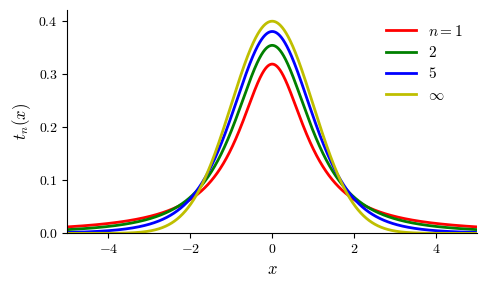

In [21]:
# t-distribution
x=np.arange(-10,10,.001)
r = [t(df).pdf(x) for df in [1,2,5]] # t-distrns for various degrees of freedom df
r+=[norm.pdf(x)] # add the normal to the list
fig, ax = plt.subplots(figsize=(5,3))
plot(x,r,
     xlim=[-5,5],
     ylim=[0,0.42],
     legend=[r'$n=$1','2','5',r'$\infty$'],
     xlabel=r'$x$',
     ylabel=r'$t_{n}(x)$',
     axes=ax
);

ax.legend_.set_frame_on(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
if Save:
    fig.savefig(str(savedir / 'inf-t-dist-n.pdf'), dpi=600, format='pdf', bbox_inches='tight');

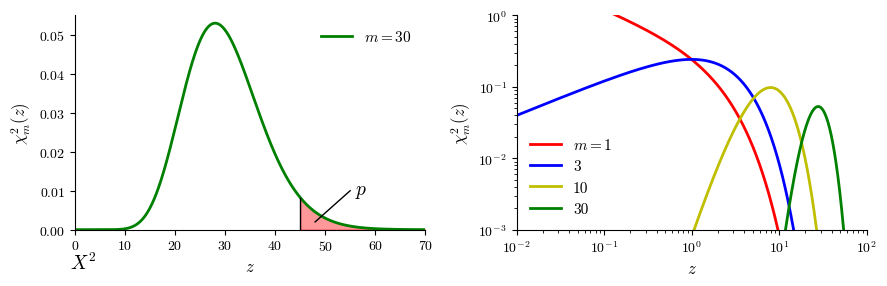

In [22]:
# Both plots together
x=np.arange(0.01,100,.01)
fig,ax=plt.subplots(1,2,figsize=(9,3))
y=chi2(30).pdf(x)
plot(x,y,
     xlim=[0,70],
     ylim=[0,0.055],
     legend=[r'$m=$30'],
     fmts=['g-'],
    xlabel=r'$z$',
    ylabel=r'$\chi^2_{m}(z)$',
     axes=ax[0]
);
xc=45
yc=y[x>xc][0]
plot([xc,xc],[0,yc],fmts=['k-'],linewidth=1,axes=ax[0]);
ax[0].fill_between(x,y,where=x>xc,color='red',alpha=0.4);
ax[0].text(c,-0.01,r'$X^2$',size = 14, ha = 'center');
plot([48,55],[0.002,0.01],fmts=['k-'],linewidth=1,axes=ax[0],
     xlim=[0,70],
     ylim=[0,0.055],
);
ax[0].text(56,0.01,r'$p$',size=14,ha='left',va='center');
# ax[0].set_xticklabels([]);

r = [chi2(df).pdf(x) for df in [1,3,10,30]]
plot(x,r,
     xlim=[0.01,100],
     ylim=[1e-3,1],
     legend=[r'$m=$1','3','10','30'],
     fmts=['r-','b-','y-','g-'],     
    xlabel=r'$z$',
    ylabel=r'$\chi^2_{m}(z)$',
     xscale='log',
     yscale='log',
     axes=ax[1]
);
fig.tight_layout()
ax[0].legend_.set_frame_on(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

ax[1].legend_.set_frame_on(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
if Save:
    fig.savefig(str(savedir / 'inf-chi-square.pdf'), dpi=600, format='pdf', bbox_inches='tight');

#### Linear regression

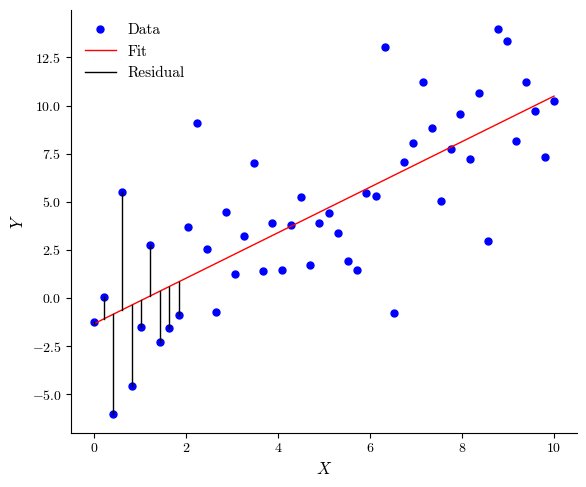

In [23]:
# for use in the book
import numpy as np
from matplotlib import pyplot as plt

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table

alpha=0.05
np.random.seed(2)
x = np.linspace(0,10)
y = 3*np.random.randn(50) + x
X = sm.add_constant(x)
res = sm.OLS(y, X).fit()

st, data, ss2 = summary_table(res, alpha=alpha)
fittedvalues = data[:,2]
predict_mean_se  = data[:,3]
predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T

pa=res.params
ci=res.conf_int(alpha=alpha)
rs=res.rsquared
pv=res.pvalues

fig, ax=plt.subplots(figsize=(6,5))
ax=plot(x,[y,fittedvalues],
        fmts=['bo','r-'],
        linewidth=1,
        markersize=5,
        xlabel=r'$X$',
        ylabel=r'$Y$',
        axes=ax,
);
for i in range(10):
    plot([x[i],x[i]],[y[i],fittedvalues[i]],
     fmts=['k-'],
     linewidth=1,
    axes=ax,
    legend=['Data','Fit','Residual'],
);
ax.legend_.set_frame_on(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
if Save:
    fig.savefig(str(savedir / 'inf-lin-reg-data.pdf'), dpi=600, format='pdf', bbox_inches='tight');

offset   = -1.33 [-3.09, 0.43] 95% CI
slope    = 1.18 [0.88, 1.49] 95% CI
rsquared = 0.56
pvalue   = 3.76e-10


/var/folders/t7/6fcx_5ws6tg6315x16vsfxxm0000gn/T/ipykernel_11118/1312849649.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


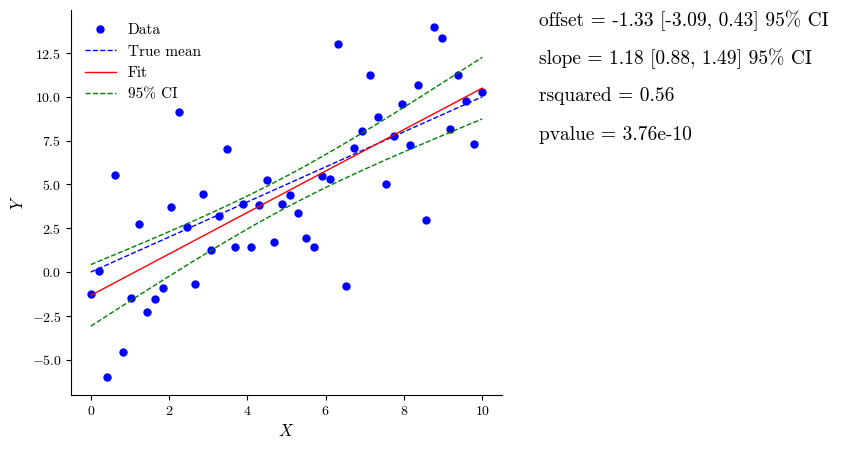

In [24]:
import numpy as np
from matplotlib import pyplot as plt

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table

alpha=0.05
np.random.seed(2)
x = np.linspace(0,10)
y = 3*np.random.randn(50) + x
X = sm.add_constant(x)
res = sm.OLS(y, X).fit()

st, data, ss2 = summary_table(res, alpha=alpha)
fittedvalues = data[:,2]
predict_mean_se  = data[:,3]
predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T

pa=res.params
ci=res.conf_int(alpha=alpha)
rs=res.rsquared
pv=res.pvalues
print('offset   = {:.2f} [{:.2f}, {:.2f}] {:.0f}% CI'.format(
    pa[0],ci[0,0],ci[0,1],100*(1-alpha)));
print('slope    = {:.2f} [{:.2f}, {:.2f}] {:.0f}% CI'.format(
    pa[1],ci[1,0],ci[1,1],100*(1-alpha)));
print('rsquared = {:.2f}'.format(rs));
print('pvalue   = {:.2e}'.format(pv[1])); # for slope only

gs_kw = dict(width_ratios=[1.4, 1],wspace=0.1)
fig,ax=plt.subplots(1,2,figsize=(10,5),gridspec_kw=gs_kw)
plot(x,[y,x,fittedvalues,predict_mean_ci_low,predict_mean_ci_upp],
     fmts=['bo','b--','r-','g--','g--'],
     linewidth=1,
     markersize=5,
    legend=['Data','True mean','Fit','{:.0f}% CI'.format(100*(1-alpha))],
     figsize=(6,5),
     xlabel=r'$X$',
     ylabel=r'$Y$',
    axes=ax[0]
);
ax[1].text(0,1,'offset = {:.2f} [{:.2f}, {:.2f}] {:.0f}% CI'.format(
    pa[0],ci[0,0],ci[0,1],100*(1-alpha)),
    va='top',fontsize=14,
);
ax[1].text(0,0.9,'slope = {:.2f} [{:.2f}, {:.2f}] {:.0f}% CI'.format(
    pa[1],ci[1,0],ci[1,1],100*(1-alpha)),
    va='top',fontsize=14,
);
ax[1].text(0,0.8,'rsquared = {:.2f}'.format(rs),
    va='top',fontsize=14,
);
ax[1].text(0,0.7,'pvalue = {:.2e}'.format(pv[1]),
    va='top',fontsize=14,
);
ax[1].axis('off')
ax[0].legend_.set_frame_on(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

if Save:
    fig.savefig(str(savedir / 'inf-lin-reg-fit.pdf'), dpi=600, format='pdf', bbox_inches='tight');

b_1   = 5.1e-01 [4.6e-01, 5.7e-01] 95% CI
b_2   = 4.7e-01 [2.5e-01, 6.9e-01] 95% CI
b_3   = -2.0e-02 [-2.5e-02, -1.5e-02] 95% CI
b_4   = 4.8e+00 [4.4e+00, 5.2e+00] 95% CI
rsquared = 0.93


/var/folders/t7/6fcx_5ws6tg6315x16vsfxxm0000gn/T/ipykernel_11118/1312849649.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


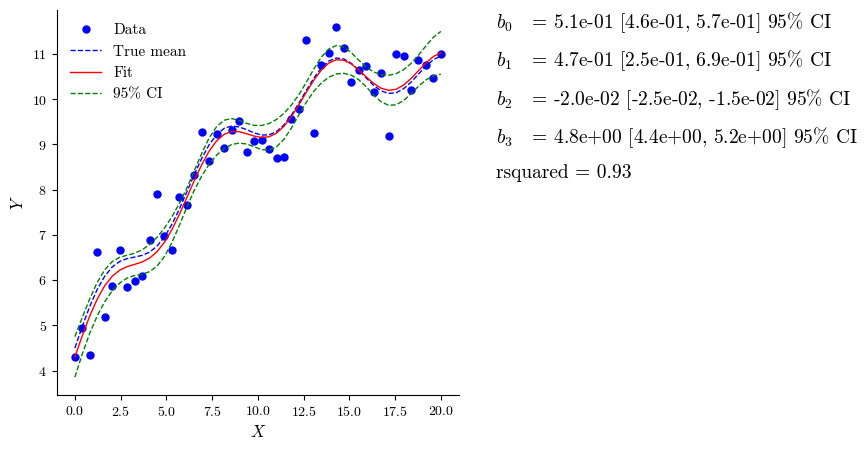

In [25]:
# multiple regression using arbitrary functions
import numpy as np
from matplotlib import pyplot as plt

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table

alpha=0.05
np.random.seed(2)
nsample = 50
sig = 0.5
x = np.linspace(0, 20, nsample)
X = np.column_stack((x, np.sin(x), (x - 5) ** 2, np.ones(nsample)))
beta = [0.5, 0.5, -0.02, 5.0]

y_true = np.dot(X, beta)
y = y_true + sig * np.random.normal(size=nsample)

res = sm.OLS(y, X).fit()

st, data, ss2 = summary_table(res, alpha=alpha)
fittedvalues = data[:,2]
predict_mean_se  = data[:,3]
predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T

pa=res.params
ci=res.conf_int(alpha=alpha)
rs=res.rsquared
pv=res.pvalues
for i in range(4):
    print('b_{:s}   = {:.1e} [{:.1e}, {:.1e}] {:.0f}% CI'.format(
        str(i+1),pa[i],ci[i,0],ci[i,1],100*(1-alpha)));
#     print('b_{:s}   = {:.2f} [{:.2f}, {:.2f}] {:.0f}% CI'.format(
#         str(i),pa[i],ci[i,0],ci[i,1],100*(1-alpha)));
print('rsquared = {:.2f}'.format(rs));

gs_kw = dict(width_ratios=[1.2, 1],wspace=0.1)
fig,ax=plt.subplots(1,2,figsize=(10,5),gridspec_kw=gs_kw)
plot(x,[y,y_true,fittedvalues,predict_mean_ci_low,predict_mean_ci_upp],
     fmts=['bo','b--','r-','g--','g--'],
     linewidth=1,
     markersize=5,
    legend=['Data','True mean','Fit','{:.0f}% CI'.format(100*(1-alpha))],
     figsize=(6,5),
     xlabel=r'$X$',
     ylabel=r'$Y$',
    axes=ax[0]
);
for i in range(4):
    ax[1].text(0,1-i*0.1,r'$b_{:s}$   = {:.1e} [{:.1e}, {:.1e}] {:.0f}% CI'.format(
        str(i),pa[i],ci[i,0],ci[i,1],100*(1-alpha)),
        va='top',fontsize=14,
);
ax[1].text(0,0.6,'rsquared = {:.2f}'.format(rs),
    va='top',fontsize=14,
);
ax[1].axis('off')
ax[0].legend_.set_frame_on(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

if Save:
    fig.savefig(str(savedir / 'inf-mult-reg-fit.pdf'), dpi=600, format='pdf', bbox_inches='tight');

### Bootstrapping

/var/folders/t7/6fcx_5ws6tg6315x16vsfxxm0000gn/T/ipykernel_11118/1312849649.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


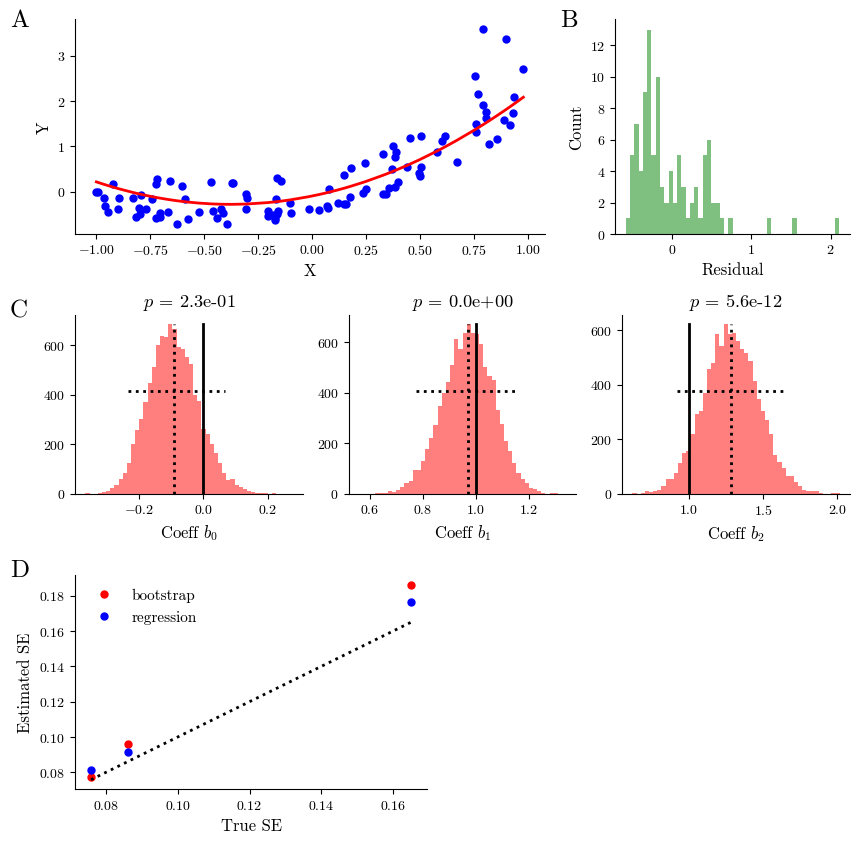

In [26]:
pa,no,k=[0,1,1],0.5,3

def poly(x,p): # returns polynomial of x with coefficients p
    M=np.array([x]*len(p)).transpose()**np.arange(len(p)) # data matrix
    return M@p # multiply with the coefficients

def poly_fit(x,y,k): # returns k coefficients for polynomial fit to y(x)
    M=np.array([x]*k).transpose()**np.arange(k) # data matrix
    C=np.linalg.inv(M.T@M) # (M^T M) ^{-1}, inverse of the covariance of the data
    return C@(M.T@y) # fit coefficients

def poly_fit_se(x,y,k): # returns k coefficients and their standard errors for polynomial fit to y(x)
    M=np.array([x]*k).transpose()**np.arange(k) # data matrix
    C=np.linalg.inv(M.T@M) # (M^T M) ^{-1}, inverse of the covariance of the data
    f=C@(M.T@y) # fit coefficients
    r=y-M@f # residual
    RSS=r.dot(r) # residual sum of squares
    s=np.sqrt(RSS/(len(M)-k)) # unbiased estimate for the std deviation \sigma
    e=s*np.sqrt(np.diagonal(C)) # standard errors of the coefficients          
    return f,e

np.random.seed(1)
m=100 # number of data points

xr=[-1,1]
x=np.sort(uniform.rvs(loc=xr[0],scale=xr[1]-xr[0],size=m)) # create the data over x=[xl,xr]
y=poly(x,pa)+(expon.rvs(scale=no,size=m)-no) # polynomial with true coefficients pa, exponential noise with mean zero

pf,sf=poly_fit_se(x,y,k) # fit the data, get coefficients and their standard errors
yf=poly(x,pf)

n=10000 # number of resamples for bootstrap
pr=[] # list of fit parameters from resamples
for _ in range(n): # for every resample
    ir=np.random.choice(m,size=m,replace=True) # resample m points with replacement
    pr+=[poly_fit(x[ir],y[ir],k)] # fit the resampled data and add result to the list
pr=np.array(pr)
sb=np.std(pr,axis=0) # standard errors from bootstrap
pv=(1-norm.cdf(np.abs(pf/sb)))*2 # two-tailed p-value for hypothesis pa=0, use std err and normal distrn
al=0.05 # significance level alpha
ps=np.sort(pr,axis=0) # sort each of the parameter lists
cl,ch=ps[int(n*al/2)],ps[int(n*(1-al/2))] # low and high confidence intervals
pe=[] # list of fit parameters from more experiments
for _ in range(n): # for every resample
    y=poly(x,pa)+(expon.rvs(scale=no,size=m)-no) # polynomial with true coefficients pa, exponential noise with mean zero
    pe+=[poly_fit(x,y,k)] # fit the data and add result to the list
pe=np.array(pe)
se=np.std(pe,axis=0) # standard errors from more experiments

if k>len(pa): # pad coefficient list with zero if needed
    pa=list(pa)+[0]*(k-len(pa))

from matplotlib import gridspec

fig = plt.figure(figsize=(10,10)); # define the figure layout; 3 rows, different gridspec in each row
spec = gridspec.GridSpec(ncols=2, nrows=3, hspace=0.4, # hspace sets vertical margin btw rows
                     width_ratios=[2,1],height_ratios=[1.2,1,1.2])
axfit = fig.add_subplot(spec[0])
axfit.spines['top'].set_visible(False)
axfit.spines['right'].set_visible(False)

axres=fig.add_subplot(spec[1])
axres.spines['top'].set_visible(False)
axres.spines['right'].set_visible(False)
spec = gridspec.GridSpec(ncols=k, nrows=3, hspace=0.4, 
                     height_ratios=[1.2,1,1.2])
axpar=[fig.add_subplot(spec[k+i]) for i in range(k)]
for ax in axpar:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
spec = gridspec.GridSpec(ncols=2, nrows=3, hspace=0.4, 
                     width_ratios=[1,1],height_ratios=[1.2,1,1.2])
axser=fig.add_subplot(spec[4])
axser.spines['top'].set_visible(False)
axser.spines['right'].set_visible(False)

plot([x,x],[y,yf],fmts=['bo','r-'],xlabel='X',ylabel='Y',axes=axfit); # plot data and fit
hist(y-yf,color='g',axes=axres,xlabel='Residual',ylabel='Count'); # histogram residual
if k>len(pa): # pad coefficient list with zero if needed
    pa=list(pa)+[0]*(k-len(pa))
for i in range(k): # for each parameter
    _,c,_,_=hist(pr[:,i],yhide=True,axes=axpar[i],xlabel=r'Coeff $b_{}$'.format(i)); # bootstrap distribution
    plot([pf[i]]*2,[0,np.max(c)],fmts=['k:'],axes=axpar[i]); # fit parameter
    plot([cl[i],ch[i]],[np.max(c)/np.sqrt(np.e)]*2,fmts=['k:'],axes=axpar[i]); # confidence interval
    plot([pa[i]]*2,[0,np.max(c)],fmts=['k-'],axes=axpar[i]); # true parameters   
    axpar[i].set_title(r'$p$ = {:1.1e}'.format(pv[i]));
plot([se,se,[np.min(se),np.max(se)]],[sb,sf,[np.min(se),np.max(se)]],
     xlabel='True SE',ylabel='Estimated SE',legend=['bootstrap','regression'],
    fmts=['ro','bo','k:'],axes=axser);
axser.legend_.set_frame_on(False)
fig.text(0.06,0.89,'A',fontsize=18,va='top',ha='left'); # adjust these label locations by trial and error
fig.text(0.61,0.89,'B',fontsize=18,va='top',ha='left');
fig.text(0.06,0.60,'C',fontsize=18,va='top',ha='left');
fig.text(0.06,0.34,'D',fontsize=18,va='top',ha='left');
if Save:
    fig.savefig(str(savedir / 'inf-bootstrap.pdf'), dpi=600, format='pdf', bbox_inches='tight');